# ***Customer Segmentation***
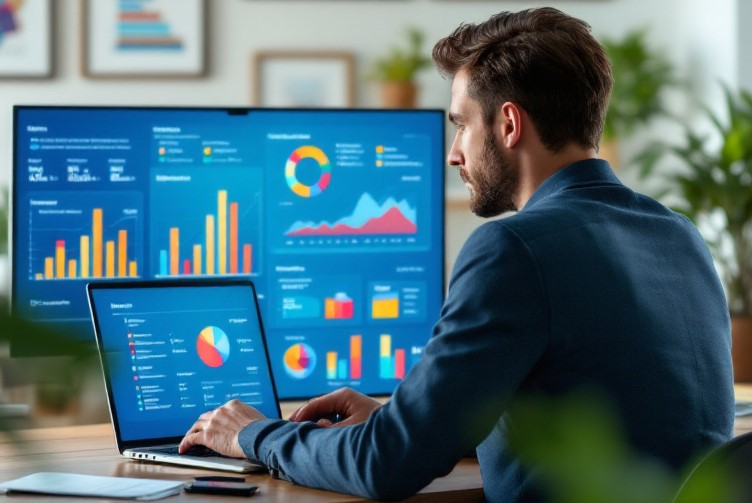

# *Problem Statement*
In the competitive landscape of online retail, understanding customer behavior and segmenting customers effectively are crucial for targeted marketing strategies and improving customer retention. The goal of this analysis is to segment customers based on their purchasing behavior using the Recency, Frequency, and Monetary (RFM) framework. By clustering customers into distinct groups, we aim to identify key customer segments such as Loyal Customers, At-Risk Customers, Champions, and New Customers.



In [69]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [70]:
sns.set(rc={'axes.facecolor': '#e0aaff'}, style='darkgrid')

### Dataset Description
The UCI Online Retail dataset is a transactional dataset that contains all the transactions occurring between 01/12/2009 and 09/12/2011 for a UK-based and registered non-store online retail.

In [71]:
df = pd.read_csv("/content/drive/MyDrive/DataSets/online_retail.csv",encoding='unicode_escape')

In [72]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

### Dataset Attributes:
* **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned
to each transaction. If this code starts with 'C', it indicates a cancellation.
* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description:** Product (item) name. Nominal.
* **Quantity:** The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country:** Country name. Nominal, the name of the country where each customer resides.

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [74]:
df.shape

(541909, 8)

* **Number of Instances**: 541,909
* **Number of Attributes**: 8
* **Missing Values**: The dataset contains missing values, particularly in the CustomerID and Description columns.

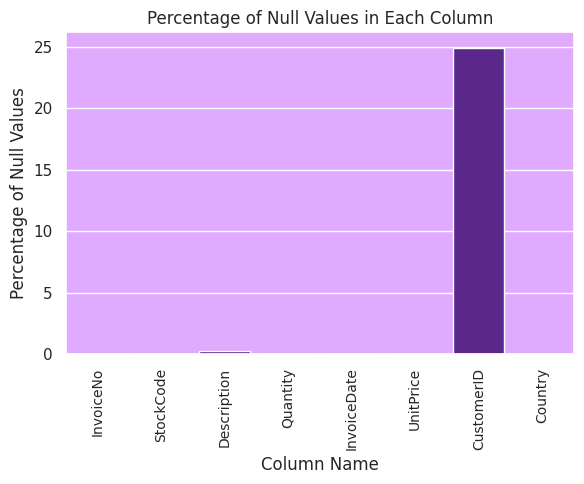

In [75]:
# Calculating the percentage of missing values in each attribute
null_percentages = (df.isnull().sum()/df.shape[0])*100
null_percentages = null_percentages.reset_index()
null_percentages.columns = ['Column Name','Percentage']

plt.figure(figsize=(6,5))
sns.barplot(data=null_percentages,x='Column Name',y='Percentage',color='#5a189a')
plt.xlabel('Column Name',fontsize = 12)
plt.ylabel('Percentage of Null Values',fontsize = 12)
plt.title('Percentage of Null Values in Each Column')
plt.xticks(rotation=90,fontsize = 10)
plt.tight_layout()
plt.show()

* The **CustomerID** column contains nearly a quarter of missing values, which poses a challenge for customer segmentation. Since this column is crucial for uniquely identifying customers and linking their purchasing patterns, handling these missing values carefully is essential.
*The **CustomerID** column contains nearly a quarter of missing values, which poses a challenge for customer segmentation. Since this column is crucial for uniquely identifying customers and linking their purchasing patterns, handling these missing values carefully is essential.

In [76]:
# Removing missing values
df.dropna(subset=['CustomerID'],inplace=True)
print(f"Null Values in the Dataset {((df.isnull().sum()/df.shape[0])*100).sum()}")

Null Values in the Dataset 0.0


In [77]:
# Duplicate Records
print(f"Duplicated Values in the Dataset {df.duplicated().sum()}")
print(f"Percentage of Duplicates {np.round((df.duplicated().sum()/df.shape[0])*100,2)}")
print("*"*45)
df[df.duplicated(keep=False)].sort_values(by='InvoiceNo')

Duplicated Values in the Dataset 5225
Percentage of Duplicates 1.28
*********************************************


InvoiceNo StockCode                          Description  Quantity  \
485       536409     22111         SCOTTIE DOG HOT WATER BOTTLE         1   
489       536409     22866        HAND WARMER SCOTTY DOG DESIGN         1   
494       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
517       536409     21866          UNION JACK FLAG LUGGAGE TAG         1   
521       536409     22900      SET 2 TEA TOWELS I LOVE LONDON          1   
...          ...       ...                                  ...       ...   
440149   C574510     22360      GLASS JAR ENGLISH CONFECTIONERY        -1   
461407   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
461408   C575940     23309  SET OF 60 I LOVE LONDON CAKE CASES        -24   
529981   C580764     22667                RECIPE BOX RETROSPOT        -12   
529980   C580764     22667                RECIPE BOX RETROSPOT        -12   

             InvoiceDate  UnitPrice  CustomerID         Country  
485      12/1/2010 11:45       4.95     17908.0  United Kingdom  
489      12/1/2010 11:45       2.10     17908.0  United Kingdom  
494      12/1/2010 11:45       1.25     17908.0  United Kingdom  
517      12/1/2010 11:45       1.25     17908.0  United Kingdom  
521      12/1/2010 11:45       2.95     17908.0  United Kingdom  
...                  ...        ...         ...             ...  
440149   11/4/2011 13:25       2.95     15110.0  United Kingdom  
461407  11/13/2011 11:38       0.55     17838.0  United Kingdom  
461408  11/13/2011 11:38       0.55     17838.0  United Kingdom  
529981   12/6/2011 10:38       2.95     14562.0  United Kingdom  
529980   12/6/2011 10:38       2.95     14562.0  United Kingdom  

[10062 rows x 8 columns]

The dataset contains **5,225** duplicate entries, accounting for **1.28%** of the total data. These duplicates will be removed to ensure the integrity and accuracy of the analysis.

In [78]:
# droping duplicates
df.drop_duplicates(inplace=True)
print(f"Duplicated Values in the Dataset {df.duplicated().sum()}")
print(f"Percentage of Duplicates {np.round((df.duplicated().sum()/df.shape[0])*100,2)}")

Duplicated Values in the Dataset 0
Percentage of Duplicates 0.0


### Cancelled Transactions

In [79]:
canceled_orders = df[df['InvoiceNo'].str.startswith('C')] # fetching records that startswith C
print(f"Total Canceled Orders {canceled_orders.shape[0]}")
print(f"Percentage of Canceled Orders {np.round((canceled_orders.shape[0]/df.shape[0])*100,2)}")
print()
print("*"*45)
canceled_orders.head(4)

Total Canceled Orders 8872
Percentage of Canceled Orders 2.21

*********************************************


InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   

         InvoiceDate  UnitPrice  CustomerID         Country  
141   12/1/2010 9:41      27.50     14527.0  United Kingdom  
154   12/1/2010 9:49       4.65     15311.0  United Kingdom  
235  12/1/2010 10:24       1.65     17548.0  United Kingdom  
236  12/1/2010 10:24       0.29     17548.0  United Kingdom

The **8,872** canceled orders, representing **2.21%** of the dataset, have been removed to ensure the analysis focuses on completed transactions and yields accurate insights.

In [80]:
print(f"Shape of the Dataset Before Cleaning cancel orders {df.shape}")
df = df[~df['InvoiceNo'].str.startswith('C')]
print(f"Shape of the Dataset After Cleaning cancel orders {df.shape}")

Shape of the Dataset Before Cleaning cancel orders (401604, 8)
Shape of the Dataset After Cleaning cancel orders (392732, 8)


In [81]:
df[df['InvoiceNo'].str.contains('[a-zA-Z]',regex=True)] # to check if there are any values that starts with characters

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

### StockCode Anomalies

In [82]:
# Anomalies in Stock code
anomaly_stock_codes = df[df['StockCode'].str.contains('^[a-zA-Z]',regex=True)]['StockCode']
print(f"Number of Anomaly Stock Codes : {anomaly_stock_codes.nunique()} \n")

for stock_code in anomaly_stock_codes.unique():
  desc = df[df['StockCode'] == stock_code]
  print(f"{stock_code} ---> {desc['Description'].iloc[0]}")

print(f"\n Total Number of Orders with Anomaly Stock Codes : {anomaly_stock_codes.shape[0]}")

Number of Anomaly Stock Codes : 6 

POST ---> POSTAGE
C2 ---> CARRIAGE
M ---> Manual
BANK CHARGES ---> Bank Charges
PADS ---> PADS TO MATCH ALL CUSHIONS
DOT ---> DOTCOM POSTAGE

 Total Number of Orders with Anomaly Stock Codes : 1549


In [83]:
# Removing all the Anomaly Stock Codes
print(f"Shape of the Dataset Before removing Anomaly Stock Codes {df.shape}")
df = df[~df['StockCode'].str.contains('^[a-zA-Z]',regex=True)]
print(f"Shape of the Dataset After removing Anomaly Stock Codes {df.shape}")

Shape of the Dataset Before removing Anomaly Stock Codes (392732, 8)
Shape of the Dataset After removing Anomaly Stock Codes (391183, 8)


### Description Anomalies

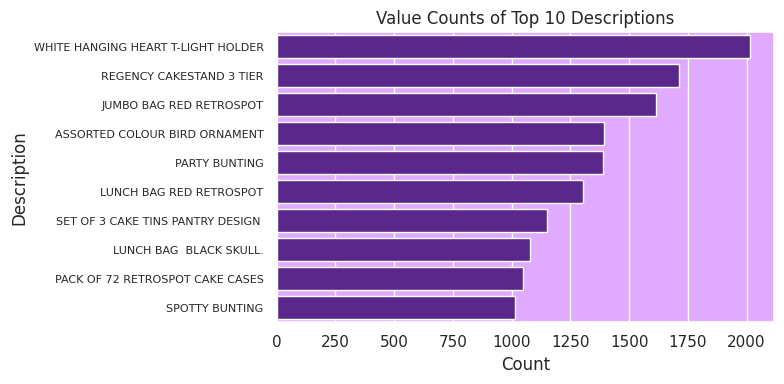

In [84]:
description = df['Description'].value_counts()[:10].reset_index()
description.columns = ['Description','Count']

plt.figure(figsize=(8,4))
sns.barplot(data=description,x='Count',y='Description',color='#5a189a')
plt.xlabel('Count',fontsize = 12)
plt.ylabel('Description',fontsize = 12)
plt.title('Value Counts of Top 10 Descriptions')
plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

From the bar graph, we can observe that product descriptions are typically entered in uppercase. Any lowercase entries might represent anomalies or errors. Therefore, it is essential to check for and handle such entries appropriately to maintain consistency in the dataset.

In [85]:
anomaly_desc = df[df['Description'].str.contains('[a-z]',regex=True)]['Description']
for desc in anomaly_desc.unique():
  print(desc)

BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
NUMBER TILE COTTAGE GARDEN No
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


The descriptions **Next Day Carriage** and **High Resolution Image** are identified as anomalies. Calculating the number of records with these descriptions is necessary, followed by appropriate handling to ensure data consistency and accuracy in the analysis.

In [86]:
df[(df['Description'] == 'Next Day Carriage') | (df['Description'] == 'High Resolution Image')].shape[0]

82

In [87]:
df = df[~((df['Description'] == 'Next Day Carriage') | (df['Description'] == 'High Resolution Image'))]


There are only **82 records** with the anomalies "Next Day Carriage" and "High Resolution Image". These records have been removed to maintain the quality and consistency of the dataset.

In [88]:
df.head(2)

InvoiceNo StockCode                         Description  Quantity  \
0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                 WHITE METAL LANTERN         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [89]:
df[['Quantity','UnitPrice']].describe()

Quantity      UnitPrice
count  391101.000000  391101.000000
mean       13.182216       2.871599
std       181.926386       4.281346
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000     649.500000

In [90]:
df = df[df['UnitPrice']>0]


The dataset contains records with a UnitPrice of 0, which is invalid. Therefore, only records with a UnitPrice greater than zero have been retained. Additionally, upon examining the descriptive statistics, it is evident that there are outliers in the data that need to be addressed.

# **RFM Analysis**
RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that helps businesses understand customer behavior and categorize them into different groups based on their purchasing patterns. It is widely used in marketing and customer relationship management to target specific customer segments effectively.

**Recency (R)** – How recently a customer made a purchase.
* Customers who purchased recently are more likely to respond to promotions.
* **Example**: A customer who bought something last week is more valuable than one who bought a year ago.

**Frequency (F)** – How often a customer makes purchases.
* Frequent buyers are more engaged and loyal to the business.
* **Example**: A customer who makes frequent purchases is more valuable than one who buys once a year.

**Monetary (M)** – How much money a customer spends.

* Customers who spend more are more valuable.
* **Example:** A customer who has spent ₹50,000 in total is more valuable than one who has spent ₹5,000.


### Recency

In [91]:
df["Date"] = pd.to_datetime(df["InvoiceDate"]) # Converting object column to datetime
reference_date = max(df["Date"]) + pd.DateOffset(days=1) # fetching the reference date
recency = (reference_date - df.groupby('CustomerID')["Date"].max()).dt.days # finding recency
recency.name = "Recency"
recency.head(2)

CustomerID
12346.0    326
12347.0      2
Name: Recency, dtype: int64

### Frequency

In [92]:
freq = df.groupby('CustomerID')['Date'].count() # calculating frequency
freq.name = "Freq"
freq.head(2)

CustomerID
12346.0      1
12347.0    182
Name: Freq, dtype: int64

### Monetary

In [93]:
df["Total_Price"] = df["Quantity"]*df["UnitPrice"] # calculating total price
monetary = df.groupby('CustomerID')['Total_Price'].sum() # monetary --> total amount spent by each customer
monetary.name = "Monetary"
monetary.head(2)

CustomerID
12346.0    77183.6
12347.0     4310.0
Name: Monetary, dtype: float64

In [94]:
# converting all the pd.Series into data frame and merging them
recency_df = recency.reset_index()
recency_df.columns = ['CustomerID', 'Recency']

frequency_df = freq.reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

monetary_df = monetary.reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

rfm = recency_df.merge(frequency_df, on="CustomerID").merge(monetary_df, on="CustomerID")

In [95]:
rfm.head()

CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2        182   4310.00
2     12348.0       75         27   1437.24
3     12349.0       19         72   1457.55
4     12350.0      310         16    294.40

In [96]:
rfm.describe().drop(columns=['CustomerID'])

Recency    Frequency       Monetary
count  4334.000000  4334.000000    4334.000000
mean     92.703046    90.232580    2015.690042
std     100.177047   224.707914    8903.655720
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     304.240000
50%      51.000000    41.000000     661.420000
75%     143.000000    98.000000    1631.622500
max     374.000000  7667.000000  279138.020000

From `rfm.describe()`, we notice some extreme values (outliers) in the dataset. These outliers can affect our analysis, so we need to identify and handle them using methods like visualization (boxplots) or statistical techniques (IQR, Z-score) for accurate segmentation.

In [97]:
# function to plot boxplots
def plot_boxplot(data):
  fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
  for idx,feature in enumerate(data.columns):
    sns.boxplot(data=data,x=feature,color='#5a189a',ax=axes[idx])
    axes[idx].set_xlabel(f'{feature}',fontsize = 10)
    axes[idx].set_title(f'Box Plot of {feature}')

  plt.tight_layout()
  plt.show()

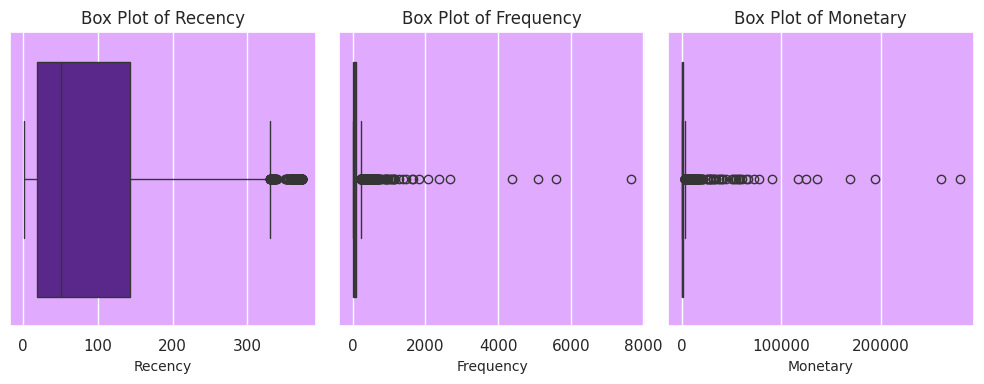

In [98]:
data = rfm.drop(columns=['CustomerID'])
plot_boxplot(data)

From the boxplots, we observe that Recency has a few outliers, while Frequency and Monetary have many. To understand their distribution better, we will perform further analysis using KDE plots.

In [99]:
# function to plot histplots
def plot_distribution(data):
  fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
  for idx,feature in enumerate(data.columns):
    sns.histplot(data=data,x=feature,color='#5a189a',ax=axes[idx],kde=True)
    axes[idx].set_xlabel(f'{feature}',fontsize = 10)
    axes[idx].set_title(f'Box Plot of {feature}')

  plt.tight_layout()
  plt.show()

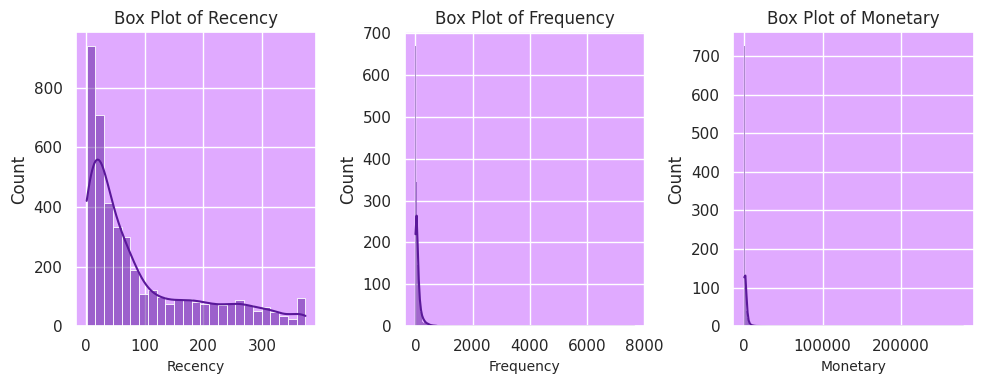

In [100]:
plot_distribution(data)

Recency, Frequency, and Monetary are right-skewed, so applying a log-normal transformation can help reduce outliers and make the distribution more balanced.

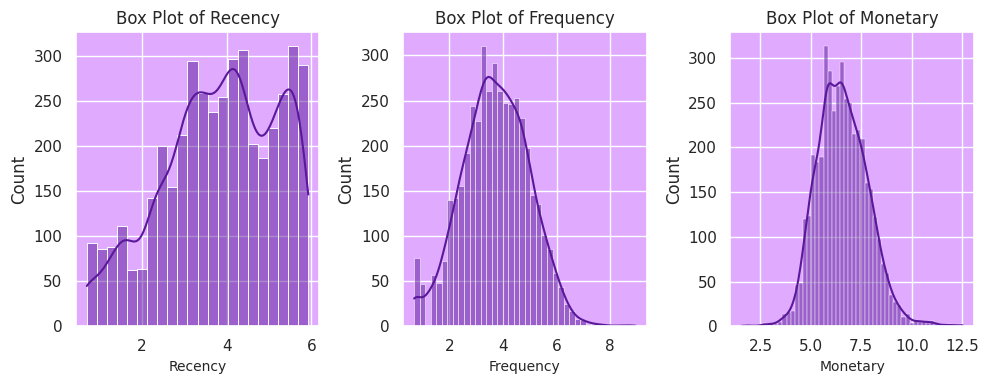

In [101]:
# applying log to recency, frequency and monetary
transformation = pd.DataFrame()

transformation['Recency'] = np.log1p(rfm['Recency'])
transformation['Frequency'] = np.log1p(rfm['Frequency'])
transformation['Monetary'] = np.log1p(rfm['Monetary'])

plot_distribution(transformation)


After applying the log transformation, we can see that Frequency and Monetary now follow a normal distribution, making the data more balanced and suitable for analysis.

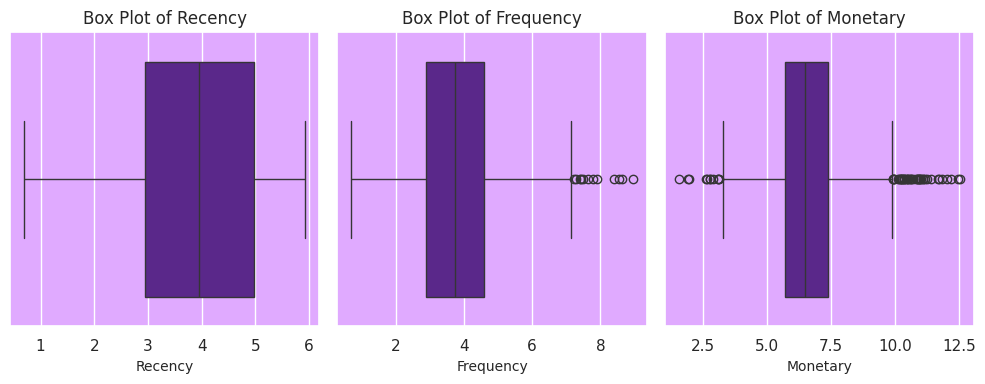

In [102]:
plot_boxplot(transformation)

From the boxplots, we observe that after applying the log transformation, Frequency and Monetary still have a few outliers. These can be easily handled using the IQR method for better accuracy in segmentation.

In [103]:
transformation.describe()

Recency    Frequency     Monetary
count  4334.000000  4334.000000  4334.000000
mean      3.832072     3.724842     6.575070
std       1.340772     1.246148     1.255304
min       0.693147     0.693147     1.558145
25%       2.944439     2.890372     5.721098
50%       3.951244     3.737670     6.495900
75%       4.969813     4.595120     7.397943
max       5.926926     8.944811    12.539465

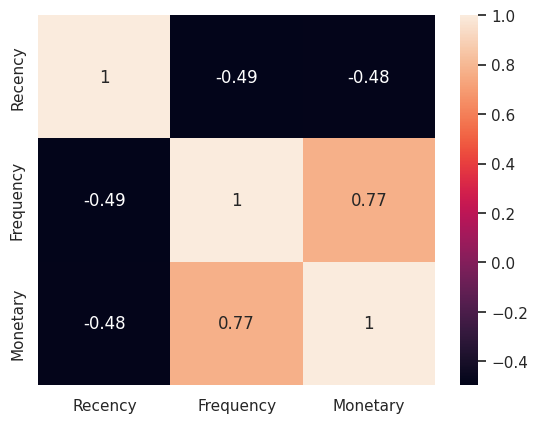

In [104]:
sns.heatmap(transformation.corr(),annot=True)
plt.show()

From the correlation analysis, we observe that Recency has a negative correlation with Frequency and Monetary, which makes sense—customers who purchase frequently tend to have lower recency values. Meanwhile, Frequency and Monetary show a positive correlation, indicating that frequent buyers also tend to spend more

In [105]:
# IQR function to calculate the outliers
def IQR_outlier(data,col):
  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR

  outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
  print(f"Number of Outliers in {col} : {outliers.shape[0]}")
  return lower_bound,upper_bound

In [106]:
lower_bound,upper_bound = IQR_outlier(transformation,'Frequency')
transformation = transformation[(transformation['Frequency'] > lower_bound) & (transformation['Frequency'] < upper_bound)]

Number of Outliers in Frequency : 12


There are 12 outliers in Frequency, which is a small number, so we can remove them to ensure a more balanced dataset for analysis.

In [107]:
lower_bound,upper_bound = IQR_outlier(transformation,'Monetary')
transformation = transformation[(transformation['Monetary'] > lower_bound) & (transformation['Monetary'] < upper_bound)]

Number of Outliers in Monetary : 44


There are 44 outliers in Monetary, which is a small number, so we can remove them to maintain a more balanced dataset for analysis.

In [108]:
transformation.describe()

Recency    Frequency     Monetary
count  4278.000000  4278.000000  4278.000000
mean      3.849925     3.710535     6.541597
std       1.327380     1.212116     1.168768
min       0.693147     0.693147     3.277145
25%       2.944439     2.890372     5.719639
50%       3.960768     3.713572     6.487684
75%       4.976734     4.584967     7.367336
max       5.926926     7.141245     9.839104

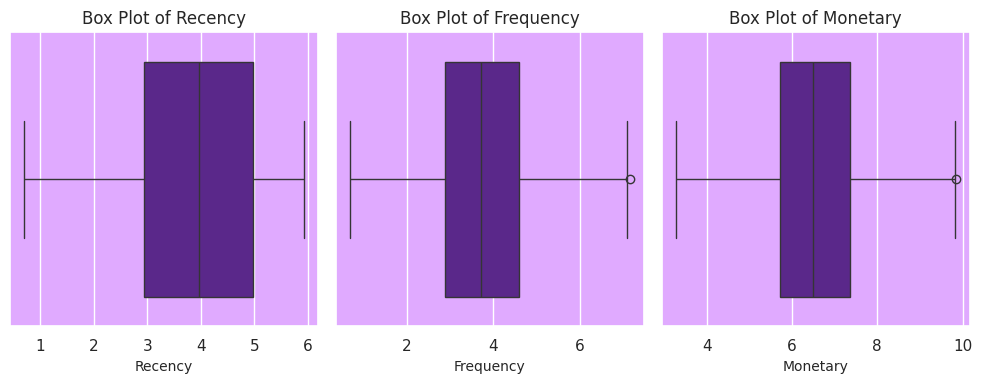

In [109]:
plot_boxplot(transformation)

In [110]:
fig = px.scatter_3d(transformation, x='Recency', y='Frequency', z='Monetary') # 3d plot for RFM
fig.show()

In [111]:
# Standardizing the columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(transformation)

In [112]:
inertia = []
score = []
for i in range(2,15):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled)
  inertia.append(kmeans.inertia_)
  score.append(silhouette_score(X_scaled,kmeans.labels_))

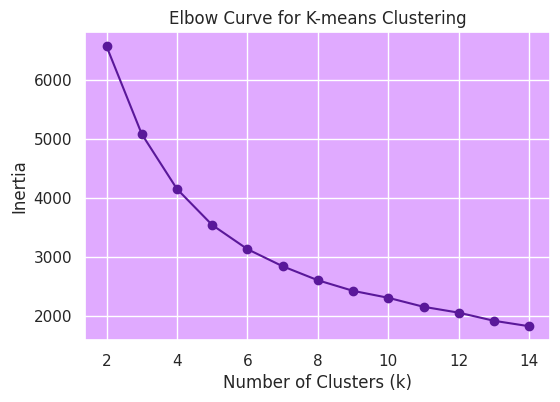

In [113]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), inertia, marker='o',color='#5a189a')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.show()

From the elbow curve, we notice that the inertia starts to dip at the 4th cluster, indicating that 4 clusters might be the optimal choice. Meanwhile, when plotting the silhouette score, we can evaluate how well the data points fit into their respective clusters. A higher silhouette score indicates better-defined clusters. Both methods help in confirming the ideal number of clusters.

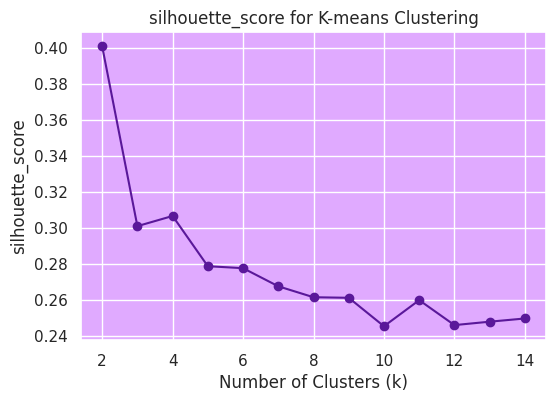

In [114]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), score, marker='o',color='#5a189a')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('silhouette_score')
plt.title('silhouette_score for K-means Clustering')
plt.grid(True)
plt.show()


From the silhouette score, we can see that the 4th cluster has the highest score, indicating that it has the best-defined clusters and is the optimal choice for segmentation.

In [115]:
# applying kmeans with 4 clusters
kmeans = KMeans(n_clusters=4,random_state=14)
kmeans.fit(X_scaled)
pred = kmeans.predict(X_scaled)
transformation['Cluster'] = pred

In [116]:
transformation.head()

Recency  Frequency  Monetary  Cluster
1  1.098612   5.209486  8.368925        2
2  4.330733   3.332205  7.271175        0
3  2.995732   4.290459  7.285198        0
4  5.739793   2.833213  5.688330        1
5  3.610918   4.356709  7.234711        0

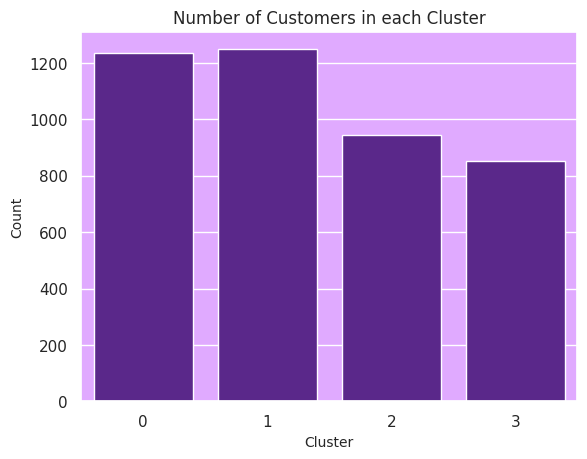

In [117]:
# number of customers in each cluster
cluster_counts = transformation['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster','Count']

sns.barplot(data=cluster_counts,x='Cluster',y='Count',color='#5a189a')
plt.xlabel('Cluster',fontsize = 10)
plt.ylabel('Count',fontsize = 10)
plt.title('Number of Customers in each Cluster')
plt.show()

In [118]:
avg_clusters = transformation.groupby('Cluster').mean()
avg_clusters = avg_clusters.reset_index()
avg_clusters

Cluster   Recency  Frequency  Monetary
0        0  4.289976   4.184950  6.987841
1        1  5.150869   2.521523  5.446587
2        2  2.322433   5.127515  7.963416
3        3  2.994559   3.196978  5.925597

This will group the data by the Cluster column and compute the mean of all features for each cluster. The resulting `avg_clusters` DataFrame will show the average values of the features (Recency, Frequency, Monetary, etc.) for each cluster, helping to understand the characteristics of each segment.

In [119]:
# labeling the clusters
cluster_label = {0: 'Loyal Customers', 1: 'At Risk', 2: 'Champions', 3: 'New Customers'}
transformation['Cluster Labels'] = transformation['Cluster'].map(cluster_label)

In [120]:
transformation.head()

Recency  Frequency  Monetary  Cluster   Cluster Labels
1  1.098612   5.209486  8.368925        2        Champions
2  4.330733   3.332205  7.271175        0  Loyal Customers
3  2.995732   4.290459  7.285198        0  Loyal Customers
4  5.739793   2.833213  5.688330        1          At Risk
5  3.610918   4.356709  7.234711        0  Loyal Customers

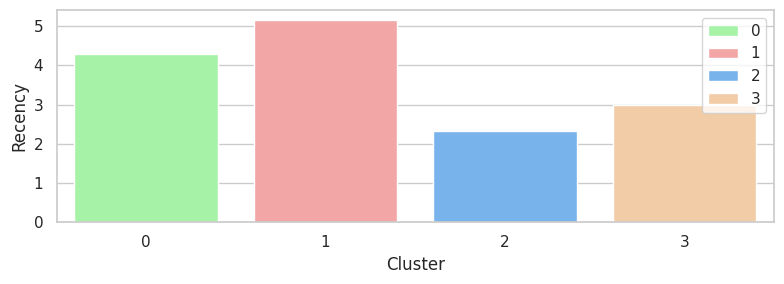

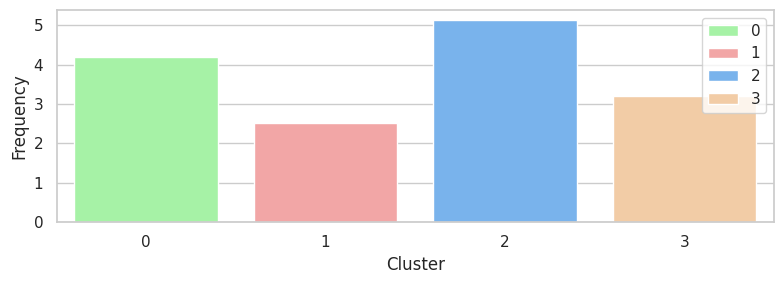

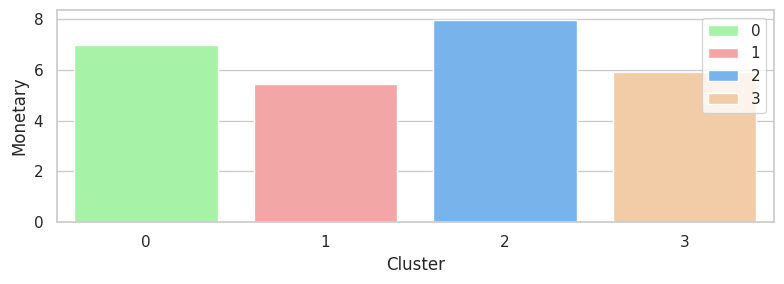

In [121]:
# bar chart of rfm
sns.set(style="whitegrid")
lst = avg_clusters.columns
colors = ['#99ff99', '#ff9999', '#66b3ff', '#ffcc99']
for i in range(1,4):
  plt.figure(figsize=(8,3))
  sns.barplot(data=avg_clusters,x='Cluster',y=lst[i],hue='Cluster',palette=colors)
  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()

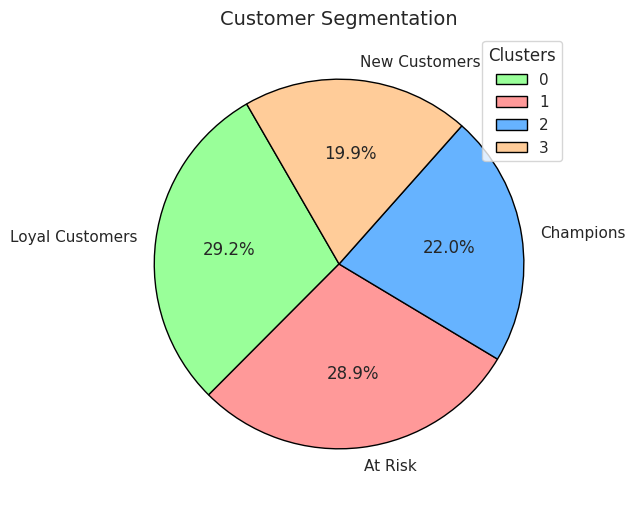

In [122]:
customers = transformation.shape[0]
labels = ['Loyal Customers','At Risk','Champions','New Customers']
sizes = (transformation["Cluster"].value_counts()/customers)*100
colors = ['#99ff99', '#ff9999', '#66b3ff', '#ffcc99']
plt.figure(figsize=(8, 6))
plt.pie(
    sizes, labels=labels, colors=colors, autopct='%1.1f%%',
    startangle=120, wedgeprops={'edgecolor': 'black'}
)
plt.title('Customer Segmentation', fontsize=14)
plt.legend([0,1,2,3],title='Clusters',loc='best',)
plt.show()

### **Customer Segmentation using RFM Analysis and K-means Clustering**

The pie chart illustrates the customer segmentation results obtained by combining RFM analysis and K-means clustering. This approach categorizes customers into four distinct groups:

* **Loyal Customers (29.2%):** This segment represents the largest portion of customer base. They are characterized by frequent purchases, high monetary value, and recent interactions. **Averange Recency, Average Frequency, Average Monetary**

* **Champions (22.0%):** These customers are brand advocates. Similar to loyal customers, they make frequent purchases and contribute significantly to revenue. **Low Recency, High Frequency, High Monetary**

* **New Customers (19.9%):** This group consists of recent additions to  customer base. **High Recency, High Frequency, High Monetary**

* **At Risk (28.9%):** This segment might require further analysis to understand their specific characteristics and behaviors. **High Recency, Average Frequency, Average Monetary**

In [129]:
custom_colors = {
    'Loyal Customers': '#99ff99',
    'Champions': '#66b3ff',
    'At Risk': '#ff9999',
    'New Customers': '#ffcc99'
}

fig = px.scatter_3d(
    transformation,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster Labels',
    color_discrete_map=custom_colors,
    labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Monetary': 'Monetary'},
    title='Customer Segmentation Visualization'
)
fig.show()

### Predictions

In [124]:
def predictions(data):
  X_data = scaler.transform(data)
  pred = kmeans.predict(X_data)
  return pred

In [125]:
def customer_segmentation():
  print("Customer Segmentation")
  data_recency = np.log1p(int(input("Enter Recency : ")))
  data_frequency = np.log1p(int(input("Enter Frequency : ")))
  data_monetary = np.log1p(int(input("Enter Monetary : ")))
  data = pd.DataFrame({'Recency': [data_recency], 'Frequency': [data_frequency], 'Monetary': [data_monetary]})
  pred = predictions(data)
  print(f"The Customer belongs to {cluster_label[pred[0]]}")

In [126]:
customer_segmentation()

Customer Segmentation
Enter Recency : 5
Enter Frequency : 7
Enter Monetary : 100
The Customer belongs to New Customers


In [127]:
customer_segmentation()

Customer Segmentation
Enter Recency : 3
Enter Frequency : 56
Enter Monetary : 6000
The Customer belongs to Champions


### **Conclusion:**
This project utilized RFM Analysis and K-means Clustering to segment customers into distinct groups, allowing us to gain deeper insights into customer behavior and preferences. By leveraging the three key RFM metrics—Recency, Frequency, and Monetary—we effectively identified four segments that can be targeted with personalized marketing strategies:

* **Loyal Customers:** High-frequency, high-spending customers who have recently interacted with the brand. This group can be nurtured with loyalty programs to maintain engagement.
* **Champions:** These customers are brand advocates, with high-frequency and high-spending behavior. Offering them exclusive offers and rewards can further solidify their loyalty.
* **New Customers:** Recently acquired customers with low frequency and monetary value. Engaging them with onboarding campaigns or personalized offers can help convert them into repeat buyers.
* **At Risk:** Customers who have not engaged recently, despite having a history of frequent purchases. Targeting them with re-engagement campaigns and special discounts may help retain them.

The use of K-means clustering alongside RFM analysis proved to be an effective method for understanding customer behavior and creating tailored strategies for each segment.

### **Made with ❤️ by Syed Afnan**